## Import Libraries and Data

In [326]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

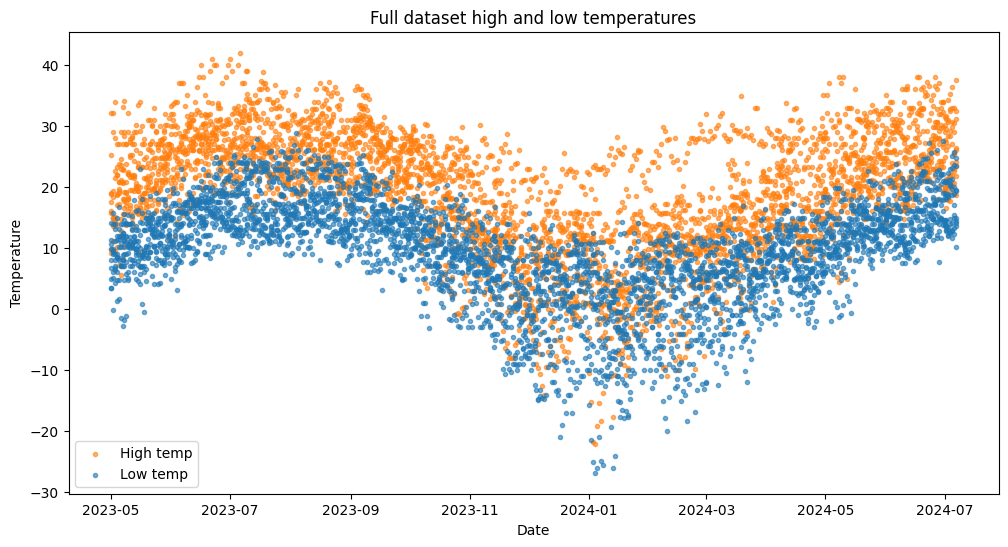

In [327]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [328]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [329]:
data.duplicated().sum()

0

In [330]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

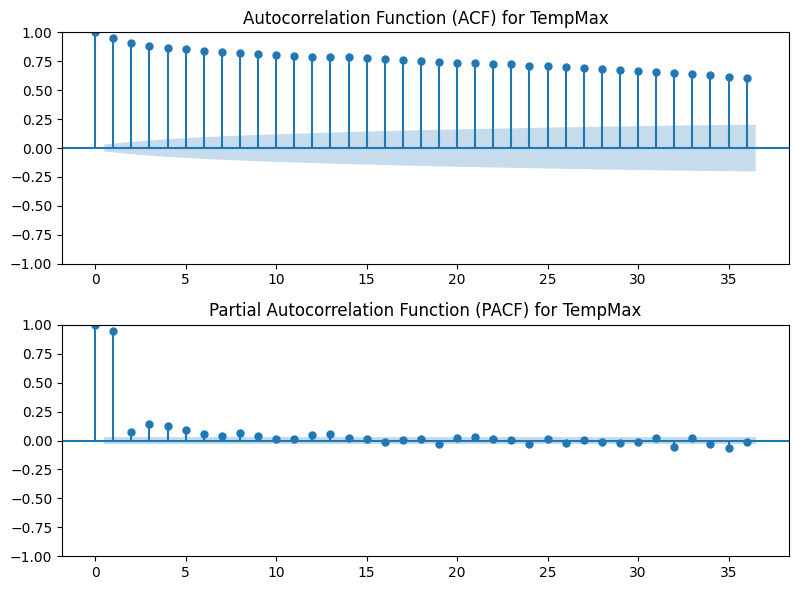

In [331]:
# Create a figure and subplots for ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Plot ACF
plot_acf(df['tempmax'], ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) for TempMax')

# Plot PACF
plot_pacf(df['tempmax'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) for TempMax')

# Adjust layout
plt.tight_layout()
plt.show()

## Identify Key Factors/Feature Selection

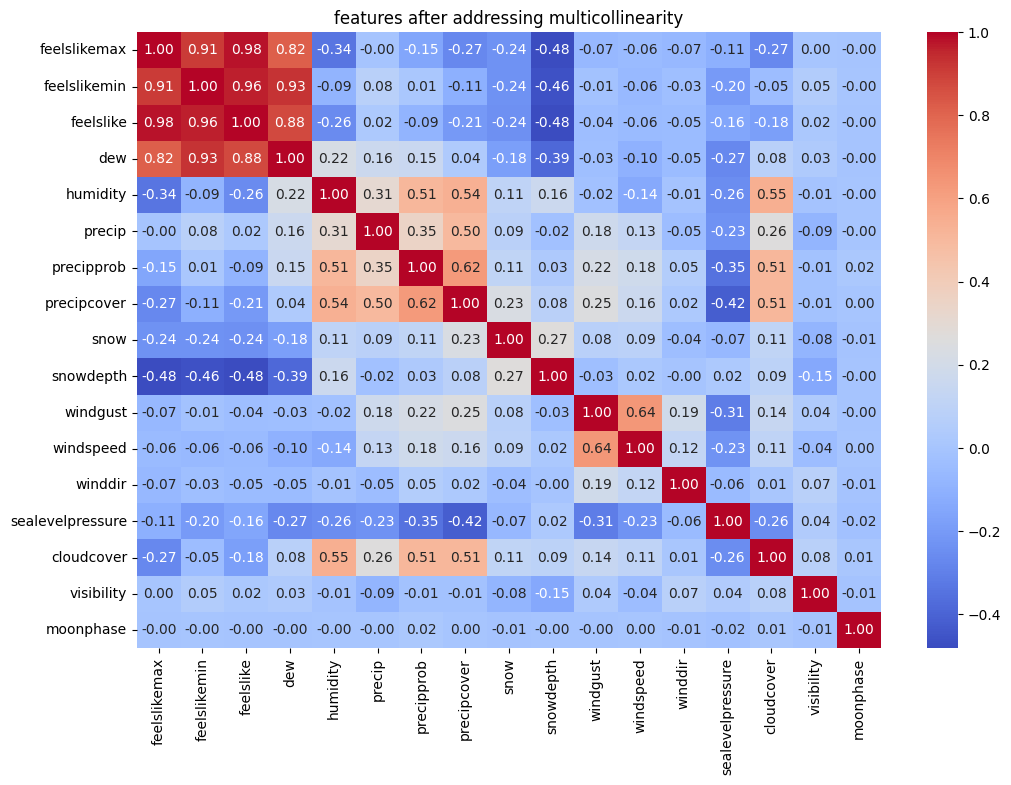

In [332]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

y_max = df['tempmax']
y_min = df['tempmin']

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(12, 8))
plt.title("features after addressing multicollinearity")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [333]:
# Define the DataFrame with combined highly correlated features
df['feelslike_max_combined'] = df[['feelslikemin', 'feelslikemax', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']]

# Define the DataFrame with combined highly correlated features specific for tempmin
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["tempmax feature"] = features_combined_max.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Display features with high VIF
print( vif_data.sort_values(by="VIF", ascending=False))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["tempmin feature"] = features_combined_min.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

# Display features with high VIF
print( vif_data.sort_values(by="VIF", ascending=False))

          tempmax feature       VIF
1            dew_humidity  6.433091
4              visibility  3.821127
0  feelslike_max_combined  3.631242
3               snowdepth  1.376002
2                    snow  1.113993
          tempmin feature       VIF
1            dew_humidity  6.065798
4              visibility  3.818570
0  feelslike_min_combined  3.083709
3               snowdepth  1.399463
2                    snow  1.116272


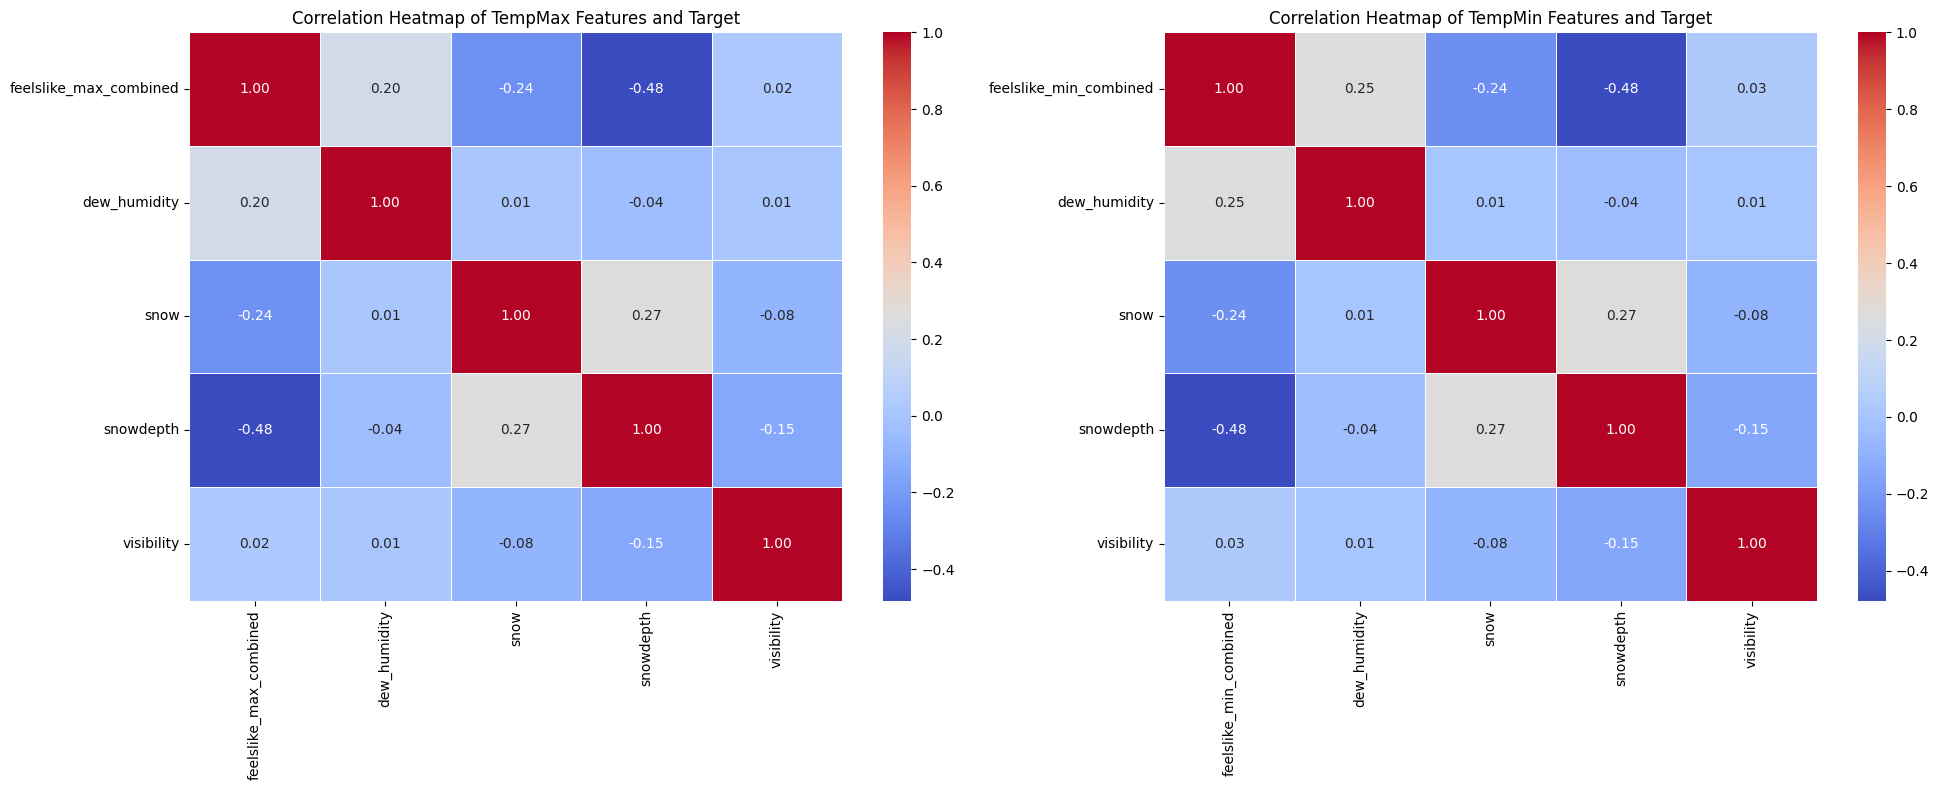

In [334]:
# Calculate combined features correlation
corr_matrix_max = features_combined_max.corr()
corr_matrix_min = features_combined_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for TempMax
sns.heatmap(corr_matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(corr_matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

## Visualize Feature/Target Relationship or Feature Importances

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [335]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X_max = ['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']
X_min = ['feelslike_min_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']

# Split training and testing data by dates
train = df.loc[df.index < '2024-03-01']
validate = df.loc[(df.index >= '2024-03-01') & (df.index < '2024-04-13')]
test = df.loc[df.index >= '2024-04-13']


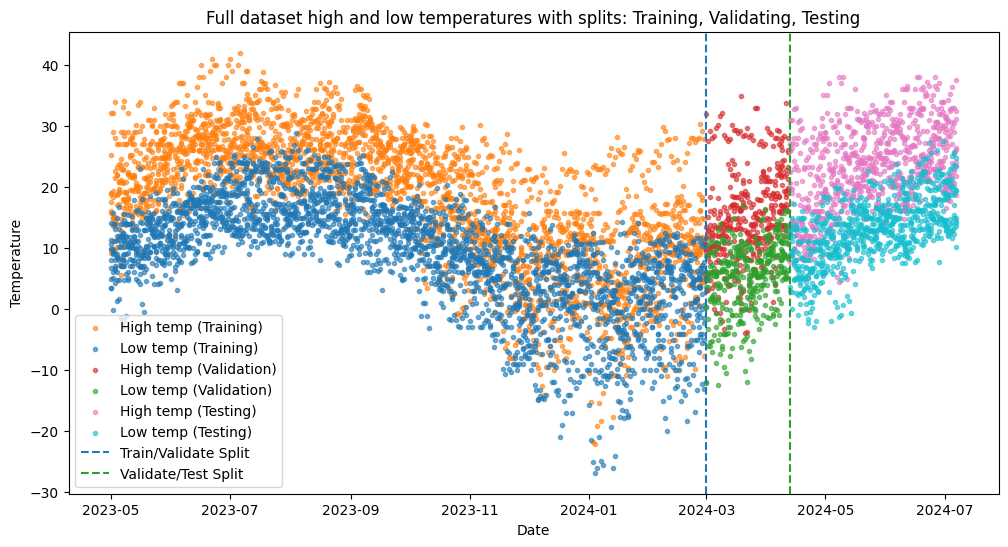

In [336]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [337]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

##  Model Cross Validation

In [338]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}

# Perform cross-validation and evaluate each model
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train_max, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {cv_scores.mean()}")

# Train the best model (replace RandomForestRegressor with the chosen model)
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train_max)
y_pred_validate_max = best_model.predict(X_validate)
r2_validate_max = r2_score(y_validate_max, y_pred_validate_max)
print(f"Best Model Validation R²: {r2_validate_max}")


Linear Regression - Cross-Validated R²: 0.9638232160792398
Ridge Regression - Cross-Validated R²: 0.963823422242322
Lasso Regression - Cross-Validated R²: 0.9626569384925947
Random Forest - Cross-Validated R²: 0.9605521256159054
Gradient Boosting - Cross-Validated R²: 0.9628189229337739
Support Vector Regression - Cross-Validated R²: 0.753077718810853
Best Model Validation R²: 0.9381268787596166


## Model Training and Evaluation

In [339]:
# Function to evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit()

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Residual analysis
    residuals = y_train - y_train_pred

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted for {model_name}')

    plt.subplot(1, 2, 2)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Autocorrelation
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.title(f'Autocorrelation of Residuals for {model_name}')
    plt.show()

In [340]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Define the parameter values based on hyperparameter tuning
alpha_max = 0.1
alpha_min = 100.0

# Initialize and fit the Ridge Regression model for tempmax
ridge_model_max = Ridge(alpha=alpha_max)
ridge_model_max.fit(X_train_max, y_train_max)

# Make predictions on the test set for tempmax
y_pred_test_max = ridge_model_max.predict(X_test_max)

# Calculate R² for test set for tempmax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for tempmax: {r2_test_max}")

# Initialize and fit the Ridge Regression model for tempmin
ridge_model_min = Ridge(alpha=alpha_min)
ridge_model_min.fit(X_train_min, y_train_min)

# Make predictions on the test set for tempmin
y_pred_test_min = ridge_model_min.predict(X_test_min)

# Calculate R² for test set for tempmin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for tempmin: {r2_test_min}")



Ridge Regression Test R² for tempmax: 0.9368963164677544
Ridge Regression Test R² for tempmin: 0.9466924794575028


Model Summary for TempMax:
                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.817e+04
Date:                Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:32:46   Log-Likelihood:                -5490.5
No. Observations:                2745   AIC:                         1.099e+04
Df Residuals:                    2739   BIC:                         1.103e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
c

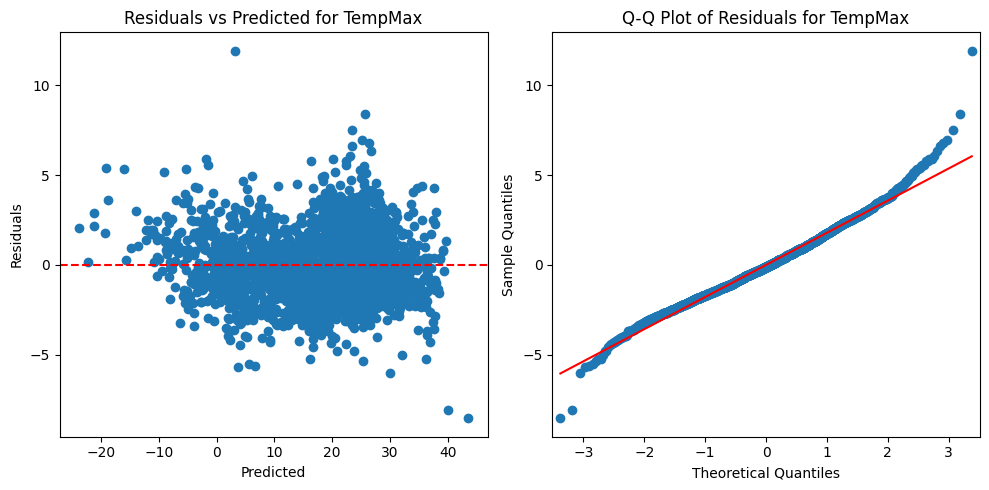

VIF for TempMax:
                   feature       VIF
0  feelslike_max_combined  3.408458
1            dew_humidity  6.354559
2                    snow  1.138952
3               snowdepth  1.467644
4              visibility  3.792465


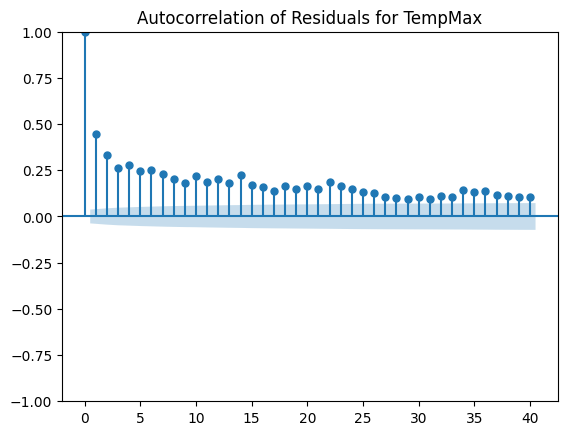

Model Summary for TempMin:
                            OLS Regression Results                            
Dep. Variable:                tempmin   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 2.051e+04
Date:                Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:32:46   Log-Likelihood:                -4874.2
No. Observations:                2745   AIC:                             9760.
Df Residuals:                    2739   BIC:                             9796.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
c

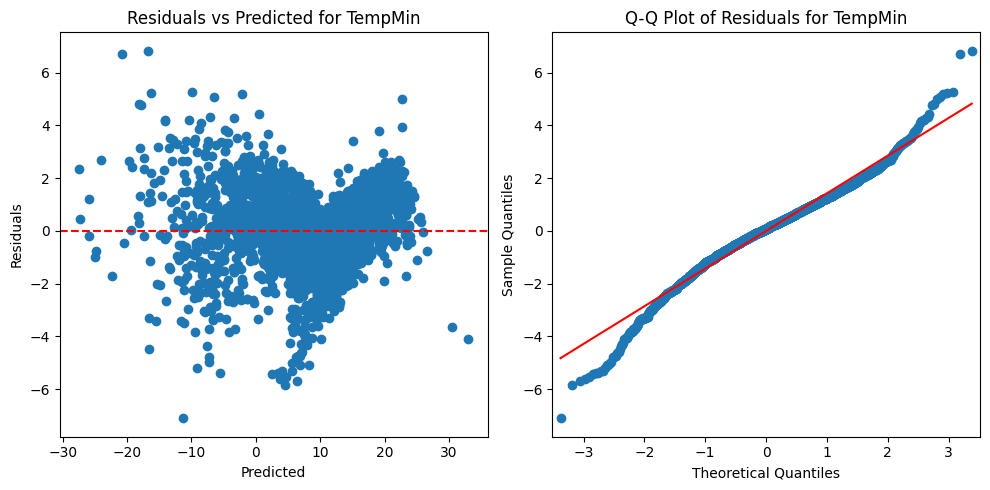

VIF for TempMin:
                   feature       VIF
0  feelslike_min_combined  2.881906
1            dew_humidity  5.939500
2                    snow  1.140880
3               snowdepth  1.487762
4              visibility  3.798674


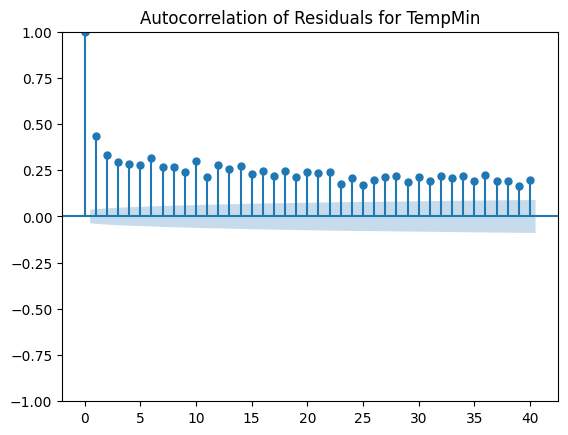

In [341]:
# Evaluate the Ridge models
evaluate_model(X_train_max, y_train_max, X_validate_max, y_validate_max, 'TempMax')
evaluate_model(X_train_min, y_train_min, X_validate_min, y_validate_min, 'TempMin')

In [342]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

# Initialize Ridge model and GridSearchCV
ridge = Ridge()
grid_search_max = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search_min = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV for tempmax
grid_search_max.fit(X_train_max, y_train_max)

# Fit GridSearchCV for tempmin
grid_search_min.fit(X_train_min, y_train_min)

# Print best parameters and best score for tempmax
print("Best Parameters for tempmax:", grid_search_max.best_params_)
print("Best Score for tempmax:", grid_search_max.best_score_)

# Print best parameters and best score for tempmin
print("Best Parameters for tempmin:", grid_search_min.best_params_)
print("Best Score for tempmin:", grid_search_min.best_score_)

# Use the best models
best_ridge_model_max = grid_search_max.best_estimator_
best_ridge_model_min = grid_search_min.best_estimator_


Best Parameters for tempmax: {'alpha': 0.1}
Best Score for tempmax: 0.9638192945703935
Best Parameters for tempmin: {'alpha': 100.0}
Best Score for tempmin: 0.963894688508554


In [343]:
# Feature importances for tempmax
importances_max = abs(best_ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

# Feature importances for tempmin
importances_min = abs(best_ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)



Feature Importances from Ridge Regression for tempmax:
                  Feature  Importance
0  feelslike_max_combined    0.985923
1            dew_humidity    0.167102
2                    snow    0.118767
3               snowdepth    0.044687
4              visibility    0.020559
Feature Importances from Ridge Regression for tempmin:
                  Feature  Importance
0  feelslike_min_combined    0.801906
2                    snow    0.141601
1            dew_humidity    0.083991
3               snowdepth    0.026908
4              visibility    0.017124


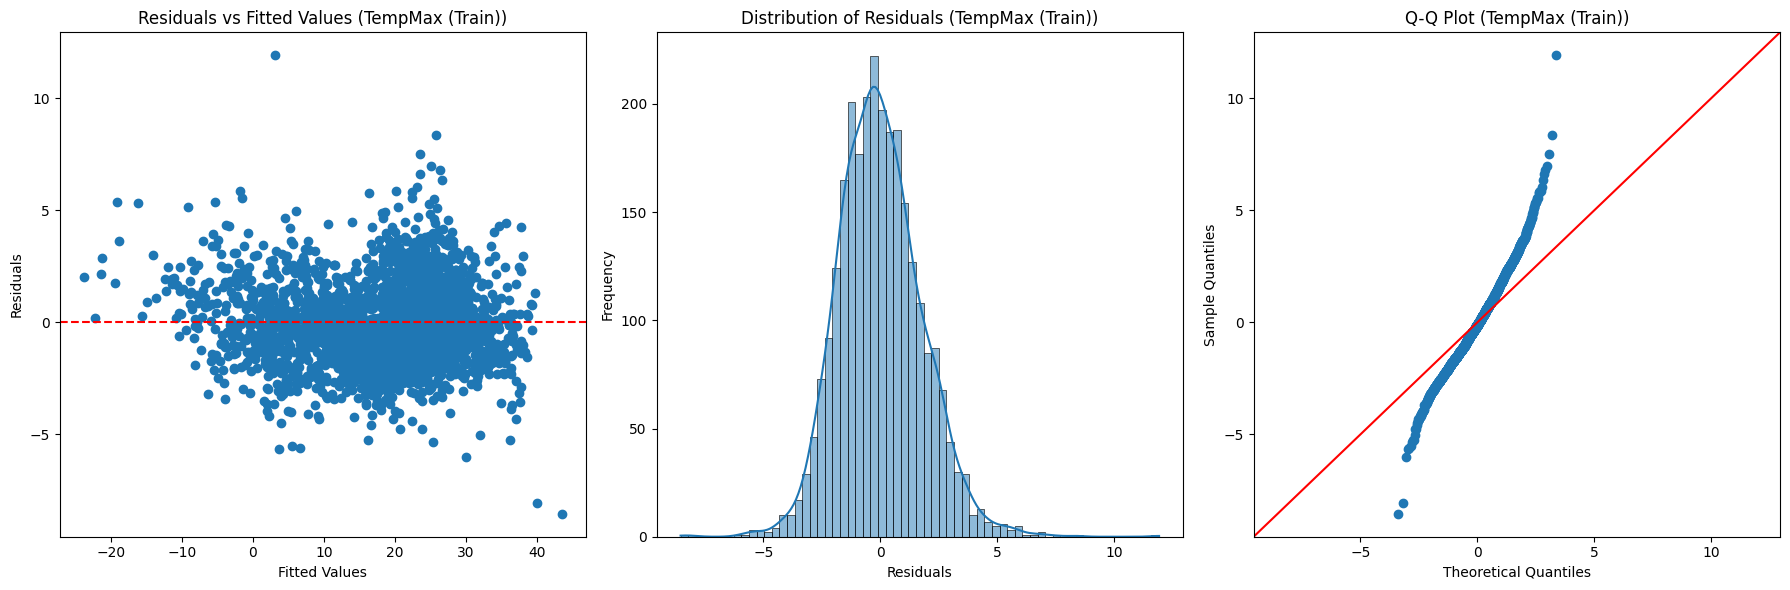

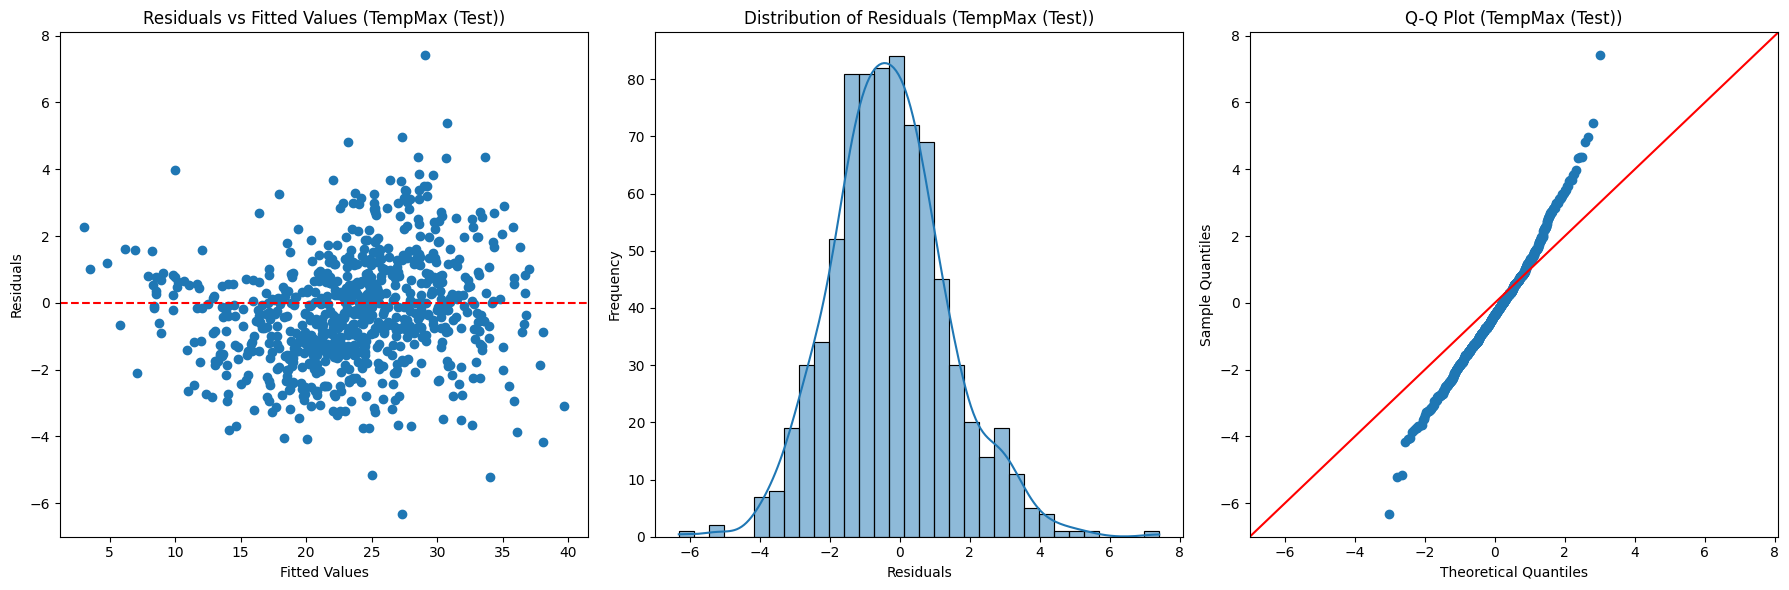

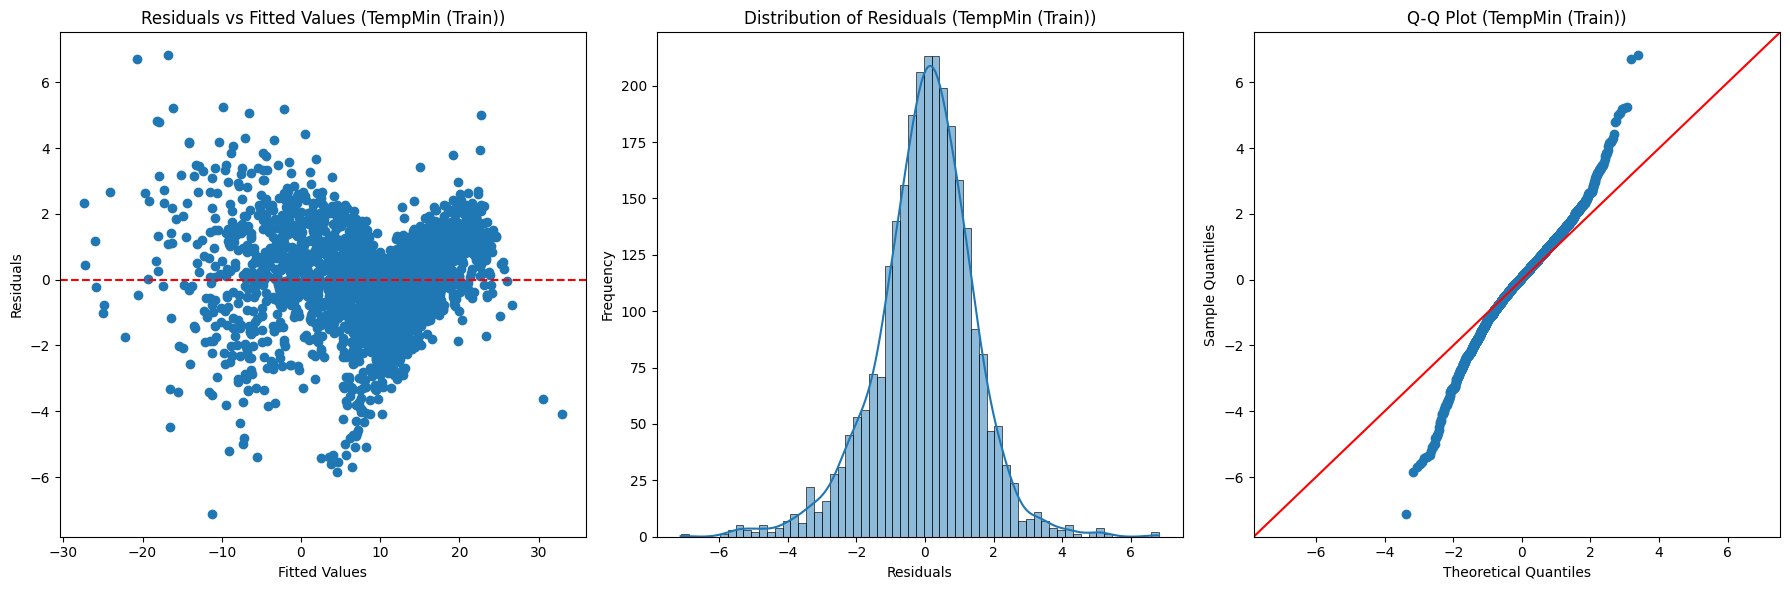

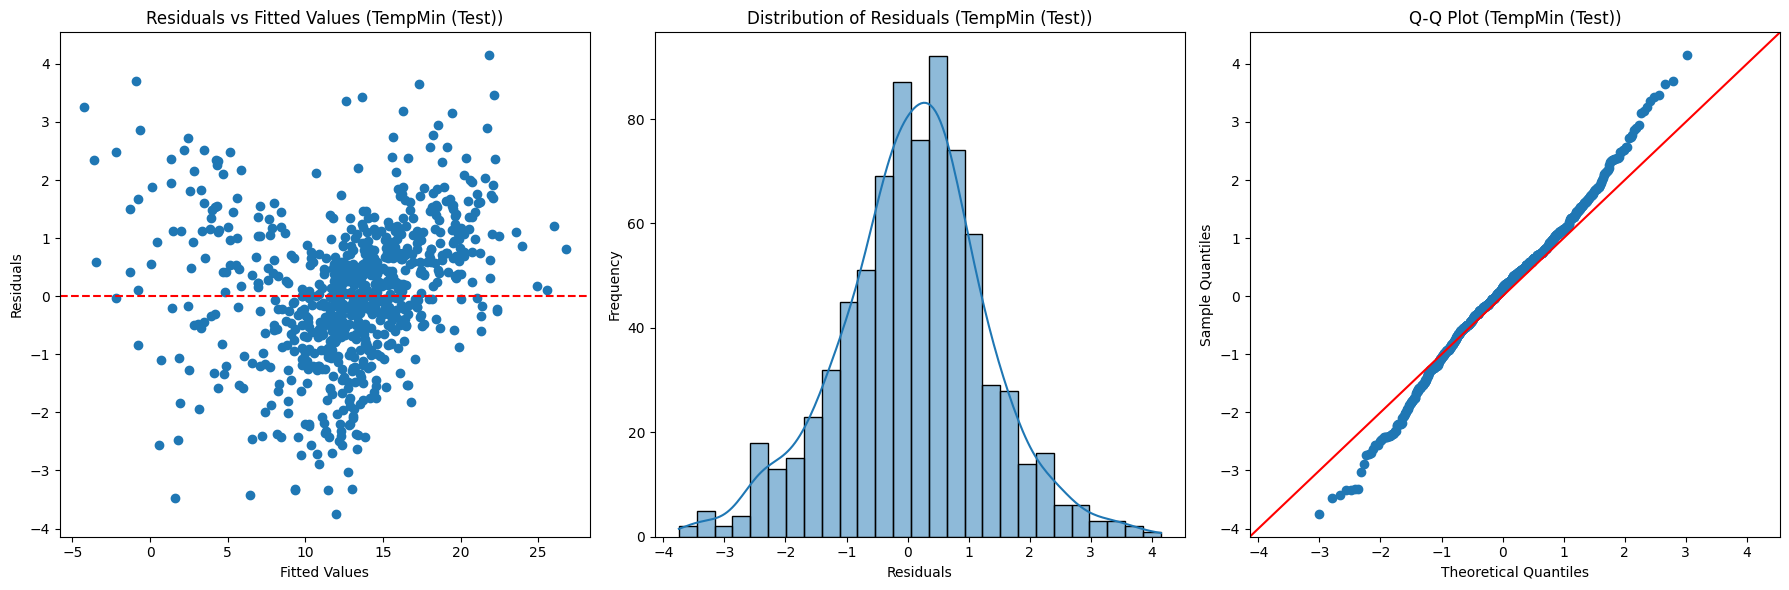

In [355]:
# Calculate residuals for tempmax
y_train_pred_max = ridge_model_max.predict(X_train_max)
y_test_pred_max = ridge_model_max.predict(X_test_max)
residuals_train_max = y_train_max - y_train_pred_max
residuals_test_max = y_test_max - y_test_pred_max

# Calculate residuals for tempmin
y_train_pred_min = ridge_model_min.predict(X_train_min)
y_test_pred_min = ridge_model_min.predict(X_test_min)
residuals_train_min = y_train_min - y_train_pred_min
residuals_test_min = y_test_min - y_test_pred_min

# Function to plot residual analysis
def plot_residuals(y_true, y_pred, residuals, title):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Residuals vs Fitted Values
    ax[0].scatter(y_pred, residuals)
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[0].set_xlabel('Fitted Values')
    ax[0].set_ylabel('Residuals')
    ax[0].set_title(f'Residuals vs Fitted Values ({title})')

    # Distribution of Residuals
    sns.histplot(residuals, kde=True, ax=ax[1])
    ax[1].set_xlabel('Residuals')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'Distribution of Residuals ({title})')

    # Q-Q Plot
    sm.qqplot(residuals, line='45', ax=ax[2])
    ax[2].set_title(f'Q-Q Plot ({title})')

    plt.tight_layout()
    plt.show()

# Plot residual analysis for TempMax (Train and Test)
plot_residuals(y_train_max, y_train_pred_max, residuals_train_max, 'TempMax (Train)')
plot_residuals(y_test_max, y_test_pred_max, residuals_test_max, 'TempMax (Test)')

# Plot residual analysis for TempMin (Train and Test)
plot_residuals(y_train_min, y_train_pred_min, residuals_train_min, 'TempMin (Train)')
plot_residuals(y_test_min, y_test_pred_min, residuals_test_min, 'TempMin (Test)')


In [345]:
import numpy as np

# Calculate residuals for TempMax
residuals_train_max = y_train_max - ridge_model_max.predict(X_train_max)
residuals_test_max = y_test_max - ridge_model_max.predict(X_test_max)

# Calculate residuals for TempMin
residuals_train_min = y_train_min - ridge_model_min.predict(X_train_min)
residuals_test_min = y_test_min - ridge_model_min.predict(X_test_min)

# Calculate kurtosis
kurtosis_train_max = kurtosis(residuals_train_max)
kurtosis_test_max = kurtosis(residuals_test_max)
kurtosis_train_min = kurtosis(residuals_train_min)
kurtosis_test_min = kurtosis(residuals_test_min)

# Perform Jarque-Bera test
jb_test_train_max = jarque_bera(residuals_train_max)
jb_test_test_max = jarque_bera(residuals_test_max)
jb_test_train_min = jarque_bera(residuals_train_min)
jb_test_test_min = jarque_bera(residuals_test_min)

# Print results
print(f'Kurtosis for TempMax (Train): {kurtosis_train_max}')
print(f'Kurtosis for TempMax (Test): {kurtosis_test_max}')
print(f'Kurtosis for TempMin (Train): {kurtosis_train_min}')
print(f'Kurtosis for TempMin (Test): {kurtosis_test_min}')

print(f'Jarque-Bera test for TempMax (Train): {jb_test_train_max}')
print(f'Jarque-Bera test for TempMax (Test): {jb_test_test_max}')
print(f'Jarque-Bera test for TempMin (Train): {jb_test_train_min}')
print(f'Jarque-Bera test for TempMin (Test): {jb_test_test_min}')


Kurtosis for TempMax (Train): 1.4681586793042865
Kurtosis for TempMax (Test): 0.8194159828177776
Kurtosis for TempMin (Train): 1.8494866336100966
Kurtosis for TempMin (Test): 0.5386121395896728
Jarque-Bera test for TempMax (Train): SignificanceResult(statistic=312.1173140341775, pvalue=1.6772059879365078e-68)
Jarque-Bera test for TempMax (Test): SignificanceResult(statistic=36.74476701486409, pvalue=1.0494825535107527e-08)
Jarque-Bera test for TempMin (Train): SignificanceResult(statistic=449.665456999709, pvalue=2.2718866588884923e-98)
Jarque-Bera test for TempMin (Test): SignificanceResult(statistic=10.894134537176729, pvalue=0.004308923092620479)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize Ridge regression model
ridge = Ridge()

# Perform GridSearchCV for TempMax
grid_search_max = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_filtered, y_train_max_boxcox)
best_alpha_max = grid_search_max.best_params_['alpha']

# Perform GridSearchCV for TempMin
grid_search_min = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_filtered, y_train_min_boxcox)
best_alpha_min = grid_search_min.best_params_['alpha']

print(f"Best alpha for TempMax: {best_alpha_max}")
print(f"Best alpha for TempMin: {best_alpha_min}")

# Initialize and fit the Ridge Regression model with best alpha for tempmax
ridge_model_max_best = Ridge(alpha=best_alpha_max)
ridge_model_max_best.fit(X_train_max_filtered, y_train_max_boxcox)

# Make predictions on the test set for tempmax
y_pred_test_max_best = ridge_model_max_best.predict(X_test_max_filtered)
y_pred_test_max_inv_best = pt_max.inverse_transform(y_pred_test_max_best.reshape(-1, 1)).flatten() - 1

# Initialize and fit the Ridge Regression model with best alpha for tempmin
ridge_model_min_best = Ridge(alpha=best_alpha_min)
ridge_model_min_best.fit(X_train_min_filtered, y_train_min_boxcox)

# Make predictions on the test set for tempmin
y_pred_test_min_best = ridge_model_min_best.predict(X_test_min_filtered)
y_pred_test_min_inv_best = pt_min.inverse_transform(y_pred_test_min_best.reshape(-1, 1)).flatten() - 1

# Evaluate the model performance
r2_test_max_best = r2_score(y_test_max_filtered, y_pred_test_max_inv_best)
r2_test_min_best = r2_score(y_test_min_filtered, y_pred_test_min_inv_best)

print(f"Ridge Regression Test R² for TempMax (Best Alpha): {r2_test_max_best}")
print(f"Ridge Regression Test R² for TempMin (Best Alpha): {r2_test_min_best}")


Best alpha for TempMax: 10
Best alpha for TempMin: 10
Ridge Regression Test R² for TempMax (Best Alpha): 0.929573613306517
Ridge Regression Test R² for TempMin (Best Alpha): 0.9504602490473083


## Retraining the Models

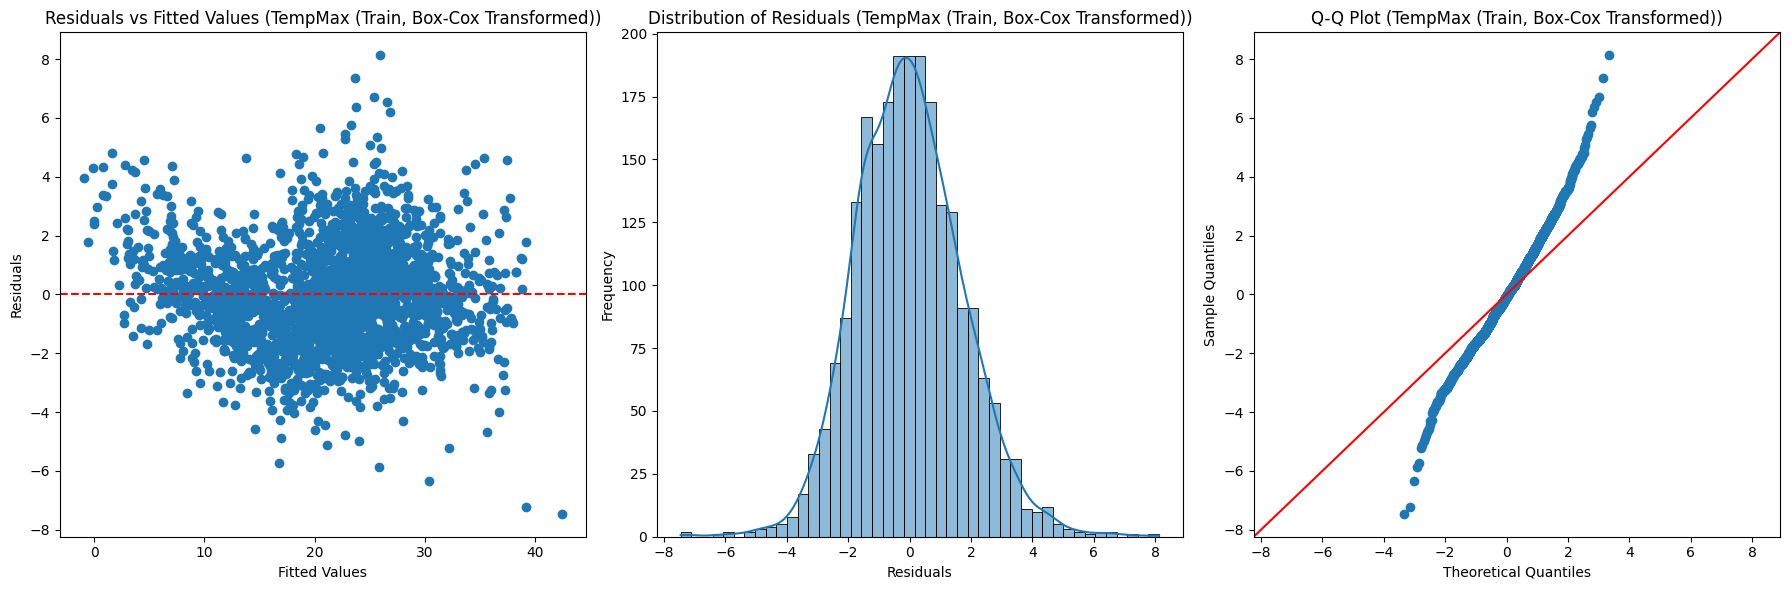

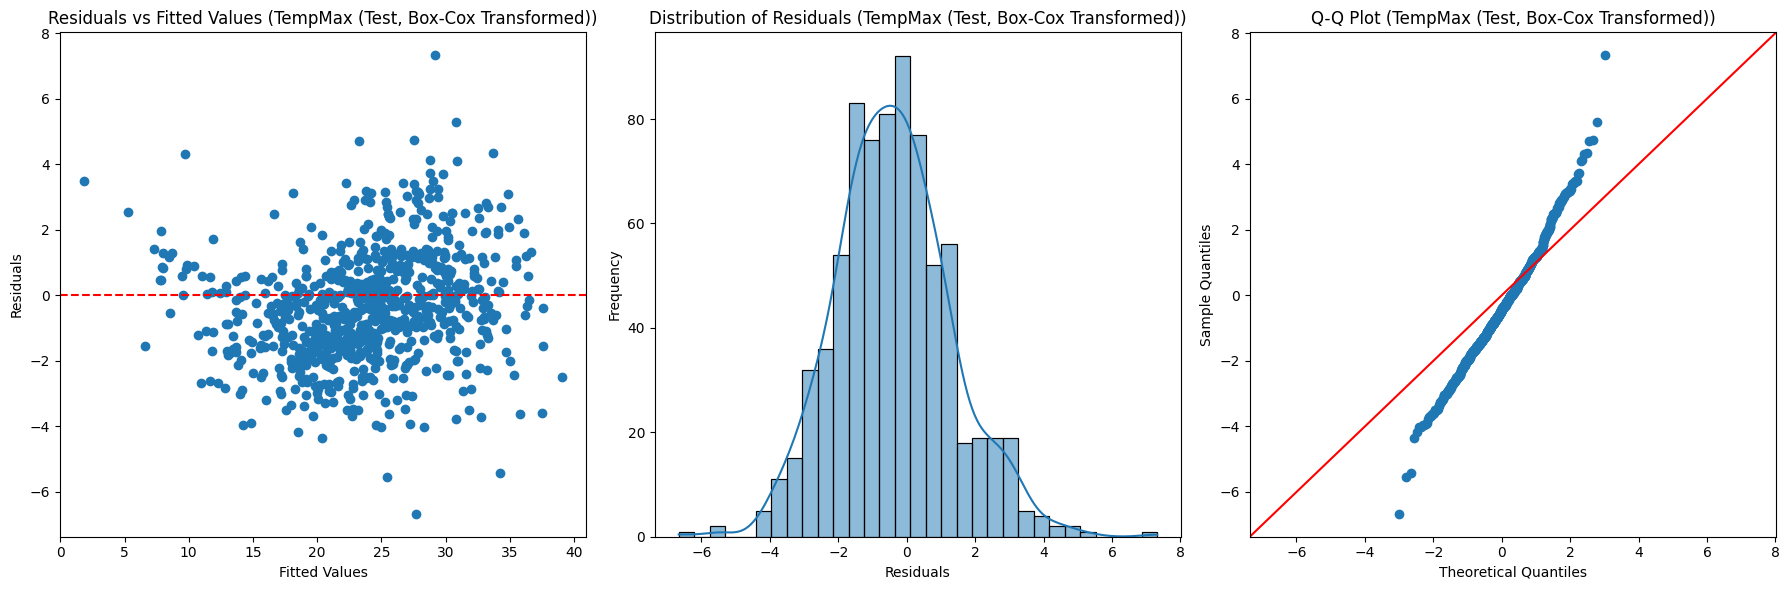

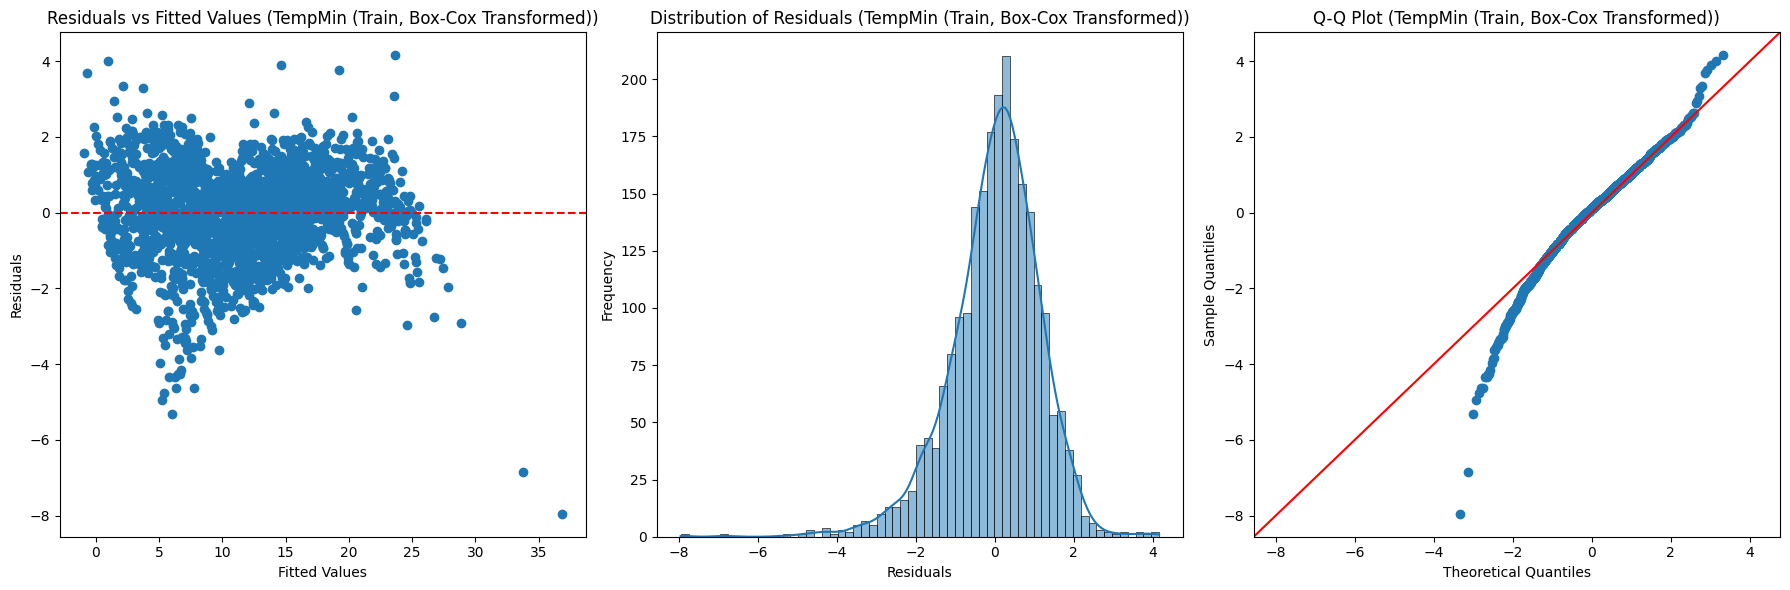

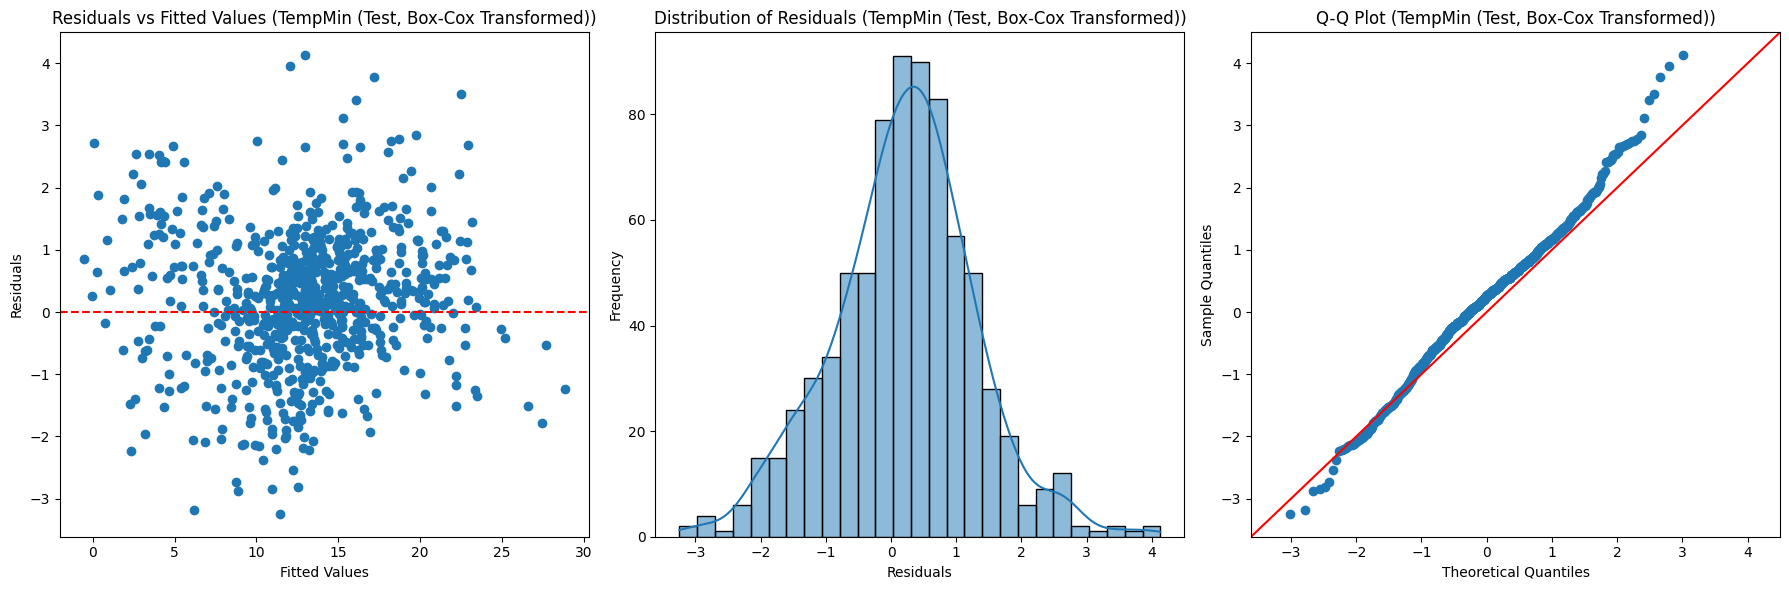

Ridge Regression Train R² for TempMax (Box-Cox Transformed): 0.9484586751924847
Ridge Regression Test R² for TempMax (Box-Cox Transformed): 0.929573613306517
Ridge Regression Train R² for TempMin (Box-Cox Transformed): 0.962791742723226
Ridge Regression Test R² for TempMin (Box-Cox Transformed): 0.9504602490473083
Ridge Regression Train MSE for TempMax (Box-Cox Transformed): 3.0068198948551013
Ridge Regression Test MSE for TempMax (Box-Cox Transformed): 3.0247432666696916
Ridge Regression Train MSE for TempMin (Box-Cox Transformed): 1.301689912218506
Ridge Regression Test MSE for TempMin (Box-Cox Transformed): 1.2222539999825903
Ridge Regression Train MAE for TempMax (Box-Cox Transformed): 1.3574237548530959
Ridge Regression Test MAE for TempMax (Box-Cox Transformed): 1.3686108864081008
Ridge Regression Train MAE for TempMin (Box-Cox Transformed): 0.8583940412622224
Ridge Regression Test MAE for TempMin (Box-Cox Transformed): 0.8582621943609614


In [360]:
from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

alpha_max = 10
alpha_min = 10

# Filter out non-positive values
train_filtered = train[(train['tempmax'] > 0) & (train['tempmin'] > 0)]
test_filtered = test[(test['tempmax'] > 0) & (test['tempmin'] > 0)]

# Define target variables after filtering
y_train_max_filtered = train_filtered['tempmax']
y_train_min_filtered = train_filtered['tempmin']
y_test_max_filtered = test_filtered['tempmax']
y_test_min_filtered = test_filtered['tempmin']

# Define feature sets after filtering
X_train_max_filtered = train_filtered[X_max]
X_test_max_filtered = test_filtered[X_max]
X_train_min_filtered = train_filtered[X_min]
X_test_min_filtered = test_filtered[X_min]

# Shift the target variables to be strictly positive
y_train_max_shifted = y_train_max_filtered + 1
y_train_min_shifted = y_train_min_filtered + 1
y_test_max_shifted = y_test_max_filtered + 1
y_test_min_shifted = y_test_min_filtered + 1

# Apply Box-Cox transformation
pt_max = PowerTransformer(method='box-cox')
pt_min = PowerTransformer(method='box-cox')

y_train_max_boxcox = pt_max.fit_transform(y_train_max_shifted.values.reshape(-1, 1)).flatten()
y_train_min_boxcox = pt_min.fit_transform(y_train_min_shifted.values.reshape(-1, 1)).flatten()
y_test_max_boxcox = pt_max.transform(y_test_max_shifted.values.reshape(-1, 1)).flatten()
y_test_min_boxcox = pt_min.transform(y_test_min_shifted.values.reshape(-1, 1)).flatten()

# Initialize and fit the Ridge Regression model for tempmax
ridge_model_max_boxcox = Ridge(alpha=alpha_max)
ridge_model_max_boxcox.fit(X_train_max_filtered, y_train_max_boxcox)

# Make predictions on the train and test set for tempmax
y_pred_train_max_boxcox = ridge_model_max_boxcox.predict(X_train_max_filtered)
y_pred_test_max_boxcox = ridge_model_max_boxcox.predict(X_test_max_filtered)

# Initialize and fit the Ridge Regression model for tempmin
ridge_model_min_boxcox = Ridge(alpha=alpha_min)
ridge_model_min_boxcox.fit(X_train_min_filtered, y_train_min_boxcox)

# Make predictions on the train and test set for tempmin
y_pred_train_min_boxcox = ridge_model_min_boxcox.predict(X_train_min_filtered)
y_pred_test_min_boxcox = ridge_model_min_boxcox.predict(X_test_min_filtered)

# Inverse Box-Cox transformation for predictions
y_pred_train_max_inv_boxcox = pt_max.inverse_transform(y_pred_train_max_boxcox.reshape(-1, 1)).flatten() - 1
y_pred_test_max_inv_boxcox = pt_max.inverse_transform(y_pred_test_max_boxcox.reshape(-1, 1)).flatten() - 1
y_pred_train_min_inv_boxcox = pt_min.inverse_transform(y_pred_train_min_boxcox.reshape(-1, 1)).flatten() - 1
y_pred_test_min_inv_boxcox = pt_min.inverse_transform(y_pred_test_min_boxcox.reshape(-1, 1)).flatten() - 1

# Handle NaN values in predictions
y_pred_train_max_inv_boxcox = np.nan_to_num(y_pred_train_max_inv_boxcox)
y_pred_test_max_inv_boxcox = np.nan_to_num(y_pred_test_max_inv_boxcox)
y_pred_train_min_inv_boxcox = np.nan_to_num(y_pred_train_min_inv_boxcox)
y_pred_test_min_inv_boxcox = np.nan_to_num(y_pred_test_min_inv_boxcox)

# Calculate residuals
residuals_train_max_boxcox = y_train_max_filtered - y_pred_train_max_inv_boxcox
residuals_test_max_boxcox = y_test_max_filtered - y_pred_test_max_inv_boxcox
residuals_train_min_boxcox = y_train_min_filtered - y_pred_train_min_inv_boxcox
residuals_test_min_boxcox = y_test_min_filtered - y_pred_test_min_inv_boxcox

# Plot residual analysis using the plot_residuals function
plot_residuals(y_train_max_filtered, y_pred_train_max_inv_boxcox, residuals_train_max_boxcox, 'TempMax (Train, Box-Cox Transformed)')
plot_residuals(y_test_max_filtered, y_pred_test_max_inv_boxcox, residuals_test_max_boxcox, 'TempMax (Test, Box-Cox Transformed)')
plot_residuals(y_train_min_filtered, y_pred_train_min_inv_boxcox, residuals_train_min_boxcox, 'TempMin (Train, Box-Cox Transformed)')
plot_residuals(y_test_min_filtered, y_pred_test_min_inv_boxcox, residuals_test_min_boxcox, 'TempMin (Test, Box-Cox Transformed)')

# Evaluate the model performance
r2_train_max_boxcox = r2_score(y_train_max_filtered, y_pred_train_max_inv_boxcox)
r2_test_max_boxcox = r2_score(y_test_max_filtered, y_pred_test_max_inv_boxcox)
r2_train_min_boxcox = r2_score(y_train_min_filtered, y_pred_train_min_inv_boxcox)
r2_test_min_boxcox = r2_score(y_test_min_filtered, y_pred_test_min_inv_boxcox)
mse_train_max_boxcox = mean_squared_error(y_train_max_filtered, y_pred_train_max_inv_boxcox)
mse_test_max_boxcox = mean_squared_error(y_test_max_filtered, y_pred_test_max_inv_boxcox)
mse_train_min_boxcox = mean_squared_error(y_train_min_filtered, y_pred_train_min_inv_boxcox)
mse_test_min_boxcox = mean_squared_error(y_test_min_filtered, y_pred_test_min_inv_boxcox)
mae_train_max_boxcox = mean_absolute_error(y_train_max_filtered, y_pred_train_max_inv_boxcox)
mae_test_max_boxcox = mean_absolute_error(y_test_max_filtered, y_pred_test_max_inv_boxcox)
mae_train_min_boxcox = mean_absolute_error(y_train_min_filtered, y_pred_train_min_inv_boxcox)
mae_test_min_boxcox = mean_absolute_error(y_test_min_filtered, y_pred_test_min_inv_boxcox)

print(f"Ridge Regression Train R² for TempMax (Box-Cox Transformed): {r2_train_max_boxcox}")
print(f"Ridge Regression Test R² for TempMax (Box-Cox Transformed): {r2_test_max_boxcox}")
print(f"Ridge Regression Train R² for TempMin (Box-Cox Transformed): {r2_train_min_boxcox}")
print(f"Ridge Regression Test R² for TempMin (Box-Cox Transformed): {r2_test_min_boxcox}")
print(f"Ridge Regression Train MSE for TempMax (Box-Cox Transformed): {mse_train_max_boxcox}")
print(f"Ridge Regression Test MSE for TempMax (Box-Cox Transformed): {mse_test_max_boxcox}")
print(f"Ridge Regression Train MSE for TempMin (Box-Cox Transformed): {mse_train_min_boxcox}")
print(f"Ridge Regression Test MSE for TempMin (Box-Cox Transformed): {mse_test_min_boxcox}")
print(f"Ridge Regression Train MAE for TempMax (Box-Cox Transformed): {mae_train_max_boxcox}")
print(f"Ridge Regression Test MAE for TempMax (Box-Cox Transformed): {mae_test_max_boxcox}")
print(f"Ridge Regression Train MAE for TempMin (Box-Cox Transformed): {mae_train_min_boxcox}")
print(f"Ridge Regression Test MAE for TempMin (Box-Cox Transformed): {mae_test_min_boxcox}")


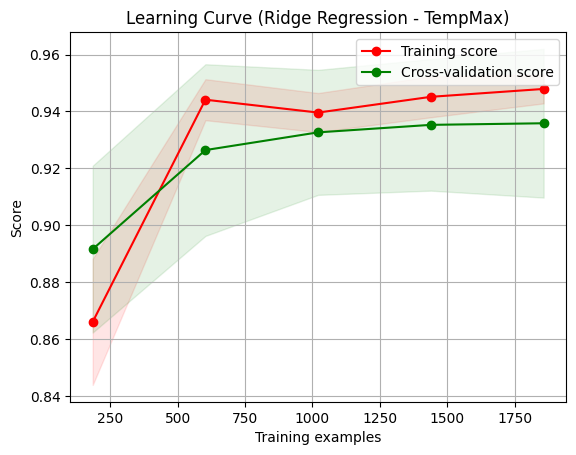

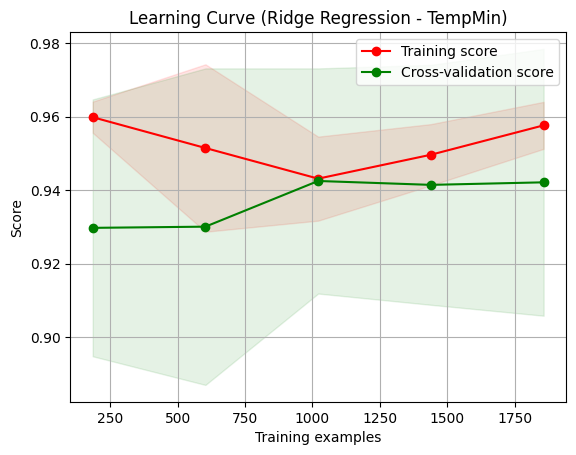

In [361]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for TempMax model
plot_learning_curve(ridge_model_max_boxcox, "Learning Curve (Ridge Regression - TempMax)",
                    X_train_max_filtered, y_train_max_boxcox, cv=5, n_jobs=-1)

# Plot learning curve for TempMin model
plot_learning_curve(ridge_model_min_boxcox, "Learning Curve (Ridge Regression - TempMin)",
                    X_train_min_filtered, y_train_min_boxcox, cv=5, n_jobs=-1)

plt.show()


# Next steps:
- Rename variables and clean/simplify notebook
- Documentation and Reporting
- Plot predicted vs actual value

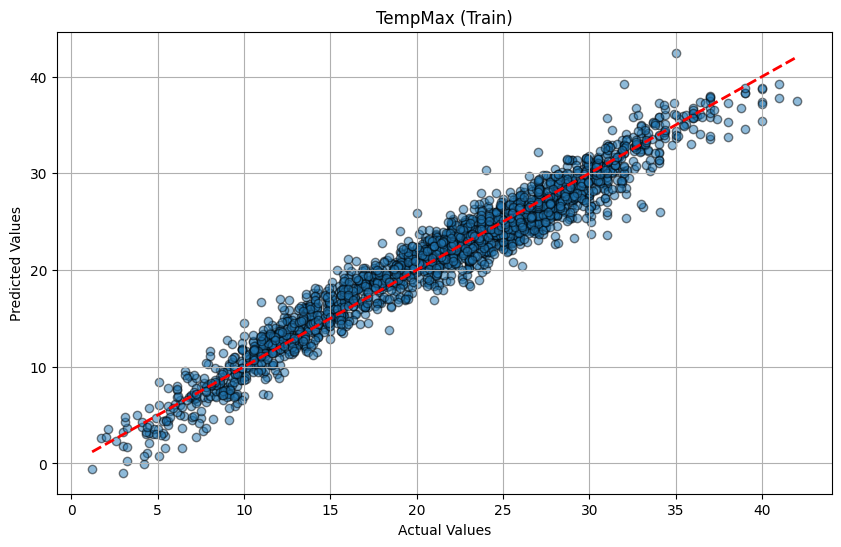

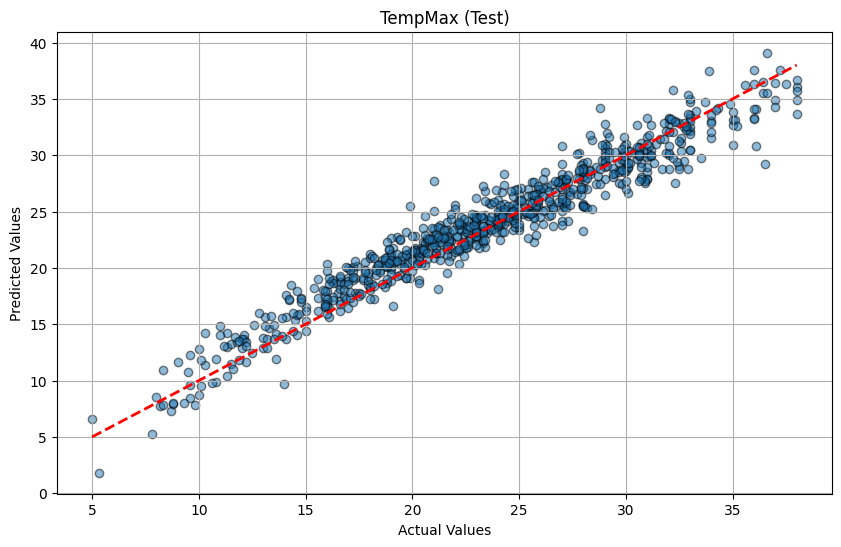

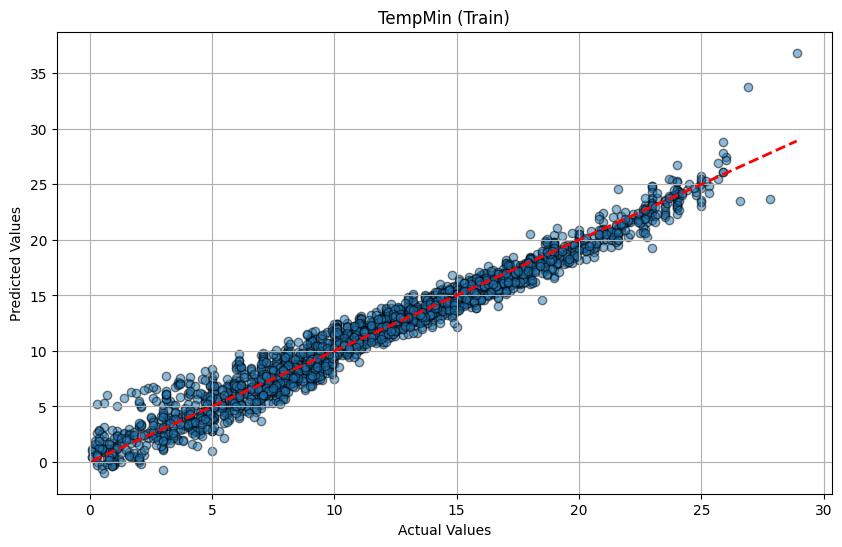

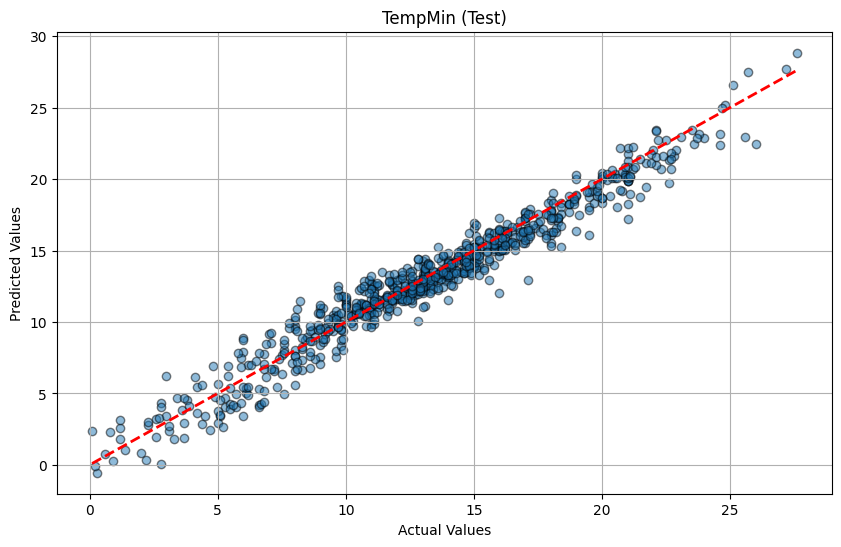

In [367]:
import matplotlib.pyplot as plt

def plot_predicted_vs_actual(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, edgecolors=(0, 0, 0), alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plot predicted vs actual for TempMax (Train)
plot_predicted_vs_actual(y_train_max_filtered, y_pred_train_max_inv_final, 'TempMax (Train)')

# Plot predicted vs actual for TempMax (Test)
plot_predicted_vs_actual(y_test_max_filtered, y_pred_test_max_inv_final, 'TempMax (Test)')

# Plot predicted vs actual for TempMin (Train)
plot_predicted_vs_actual(y_train_min_filtered, y_pred_train_min_inv_final, 'TempMin (Train)')

# Plot predicted vs actual for TempMin (Test)
plot_predicted_vs_actual(y_test_min_filtered, y_pred_test_min_inv_final, 'TempMin (Test)')
